<center><h1>Neuroscience Final Project</h1></center>
<center><h2>Deep Q Networks</h2></center>

In this notebook, we are going to get familiar with Deep Q Networks. You have been introduced to Reinforcement Learning in the course. Deep Q Networks are an entension of Reinforcement Learning were we incorporate Deep Neural Networks in our policy enhacement procedure.

We also implement an Agent in an online learning environment, meaning that the agent has no initial memory of the rewards in each state. We go through the environment based on our policy and store the observed rewards and corresponding state in the memory of the agent

Finally, we utilize the Agent in a practical Maze Solving problem. The agent is prompted to iterate the maze from a defined starting point to an ending point, maximing the profit from the total route.

**Name** : Radin Khayyam

**Student ID**: 99101579

## Importing the necessary packages

In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Creating the Deep Q Network

In [ ]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        # Calculate the forward pass. Use Proper non-linear activation function between the linear layers
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        return actions

## Creating the Agent

In [ ]:
class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0

        # Create an instance of te Deep Q network with 256 neurons in each of its hidden layers
        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=256, fc2_dims=256)

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)


    # Store one episode alongside its reward, state, next_state
    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1


    # Choose the best action with probability (1 - epsilon), otherwise choose a random direction from the action space
    # The best action is defined as the maximum output of the Deep Q Network
    def choose_action(self, observation):
        if np.random.random() < 1 - self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device)
            action = T.argmax(self.Q_eval(state)).item()
        else:
            action = np.random.choice(self.action_space)
        return action

    # Train the Deep Q Network based on the new observations
    # The network must learn the target Q values through regression
    def learn(self):
        # Simply ignore the training phase if there is not enough memory stored yet
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        # Choose a random batch of data from the memory
        batch = np.random.choice(min(self.mem_cntr, self.mem_size),self.batch_size, replace=False)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(
                self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(
                self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(
                self.terminal_memory[batch]).to(self.Q_eval.device)
        # Current state Q-value as predicted by the network
        # Note to filter the matrix to only q-values corresponding to our "action_batch"
        q_eval = self.Q_eval.forward(state_batch)[np.arange(self.batch_size, dtype=np.int32),action_batch]

        # Next state Q-value as predicted by the network for all possible next actions
        q_next = self.Q_eval(new_state_batch).max(1)[0]
        q_next[terminal_batch] = 0.0

        # The target Q-value of our current state with a discount factor of gamma
        q_target = reward_batch + self.gamma * q_next

        # Make the network learn this target Q-value via a proper definitio of loss function
        loss = F.smooth_l1_loss(q_eval, q_target.detach())
        self.Q_eval.optimizer.zero_grad()
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1

        # Reduce the epsilon by its decay factor it possible
        if self.epsilon > self.eps_min:
             self.epsilon = self.epsilon - self.eps_dec
        else:
             self.epsilon = self.eps_min

## Working with the Maze environment

In [ ]:
from maze import MazeEnvironment
import warnings
warnings.filterwarnings('ignore')

def doExp(batch_size, epsilon, gamma, lr, n_games=100):
    env = MazeEnvironment(dim=50, maze_path='maze1.npy')
    agent = Agent(gamma=gamma, epsilon=epsilon, batch_size=batch_size, n_actions=4, eps_end=0.1, input_dims=[2], lr=lr)
    scores = []
    for i in range(n_games):
        score = 0
        done = False
        observation = env.reset()
        counter = 0
        while not done:
            counter += 1
            # If performed 1000 moves and didn't finish the maze, reset the environment
            if counter == 1000:
                print(f"Episode {i}: Reached max steps. Resetting environment.")
                observation = env.reset()
                break

            # Make the agent choose an action
            action = agent.choose_action(observation)
            # Retrieve the reward and next_state from the envirinment
            observation_, reward, done = env.step(action)
            score += reward
            # Store the current episode in the memory
            agent.store_transition(observation, action, reward, observation_, done)
            # Learn the current episode
            agent.learn()
            # Change the next state to the current state
            observation = observation_

        scores.append(score)
        avg_score = np.mean(scores[-100:])
        print(f'episode {i}, score {score:.2f}, average score {avg_score:.2f}, epsilon {agent.epsilon:.2f}')
    return scores




## Report

Try to manipulate constants such as batch_size, epsilon, gamma, .... Try to achieve the maximum score.

Grading will not be based on the best scores. However, higher scores can bring bonus grade!

Plot the incrementation of your score through n games and try to justify the patterns.

# **Effect of Gamma:**

In [ ]:
# Define lists of hyperparameters to explore
batch_sizes = [8]
epsilons = [1.0]
gammas = [0.99, 0.9, 0.7, 0.5]
learning_rates = [0.001]
n_games = 100

all_scores = []
experiment_labels = []
# Perform experiments for all combinations of hyperparameters
for batch_size in batch_sizes:
    for epsilon in epsilons:
        for gamma in gammas:
            for lr in learning_rates:
                experiment_label = f"batch_size={batch_size}, epsilon={epsilon}, gamma={gamma}, lr={lr}"
                print(f"Running experiment with {experiment_label}, n_games={n_games}")
                scores = doExp(batch_size=batch_size, epsilon=epsilon, gamma=gamma, lr=lr, n_games=n_games)
                all_scores.append(scores)
                experiment_labels.append(experiment_label)


Running experiment with batch_size=8, epsilon=1.0, gamma=0.99, lr=0.001, n_games=100


AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

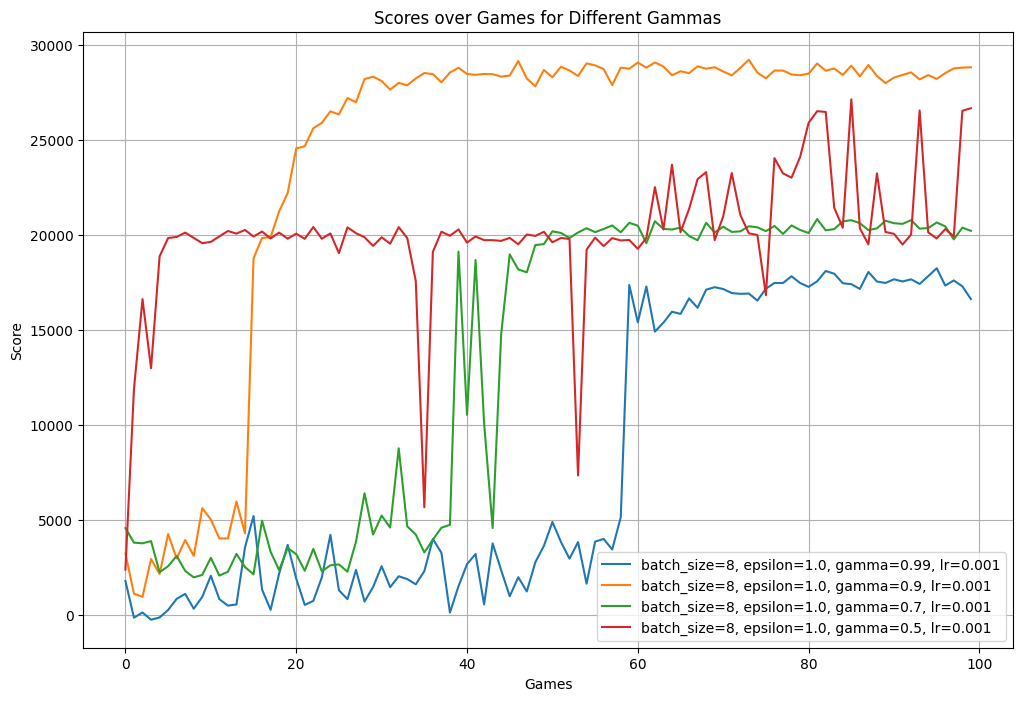

In [ ]:
# Plotting the scores
plt.figure(figsize=(12, 8))
for i, scores in enumerate(all_scores):
    plt.plot(scores, label=experiment_labels[i])
plt.xlabel('Games')
plt.ylabel('Score')
plt.title('Scores over Games for Different Gammas')
plt.legend()
plt.grid(True)
plt.show()

As we can see, best result is for gamma = 0.9.

# **Effect of batch size:**

In [ ]:
# Define lists of hyperparameters to explore
batch_sizes = [4, 8, 16, 32]
epsilons = [1.0]
gammas = [0.9]
learning_rates = [0.001]
n_games = 100

all_scores = []
experiment_labels = []
# Perform experiments for all combinations of hyperparameters
for batch_size in batch_sizes:
    for epsilon in epsilons:
        for gamma in gammas:
            for lr in learning_rates:
                experiment_label = f"batch_size={batch_size}, epsilon={epsilon}, gamma={gamma}, lr={lr}"
                print(f"Running experiment with {experiment_label}, n_games={n_games}")
                scores = doExp(batch_size=batch_size, epsilon=epsilon, gamma=gamma, lr=lr, n_games=n_games)
                all_scores.append(scores)
                experiment_labels.append(experiment_label)

Running experiment with batch_size=4, epsilon=1.0, gamma=0.9, lr=0.001, n_games=100
Episode 0: Reached max steps. Resetting environment.
episode 0, score 1283.00, average score 1283.00, epsilon 0.50
episode 1, score 2778.00, average score 2030.50, epsilon 0.23
episode 2, score 1959.00, average score 2006.67, epsilon 0.10
episode 3, score 1686.00, average score 1926.50, epsilon 0.10
episode 4, score 2083.00, average score 1957.80, epsilon 0.10
episode 5, score 2789.00, average score 2096.33, epsilon 0.10
episode 6, score 4233.00, average score 2401.57, epsilon 0.10
episode 7, score 4044.00, average score 2606.88, epsilon 0.10
episode 8, score 2782.00, average score 2626.33, epsilon 0.10
episode 9, score 2611.00, average score 2624.80, epsilon 0.10
episode 10, score 2698.00, average score 2631.45, epsilon 0.10
episode 11, score 2960.00, average score 2658.83, epsilon 0.10
episode 12, score 2301.00, average score 2631.31, epsilon 0.10
episode 13, score 2678.00, average score 2634.64, epsi

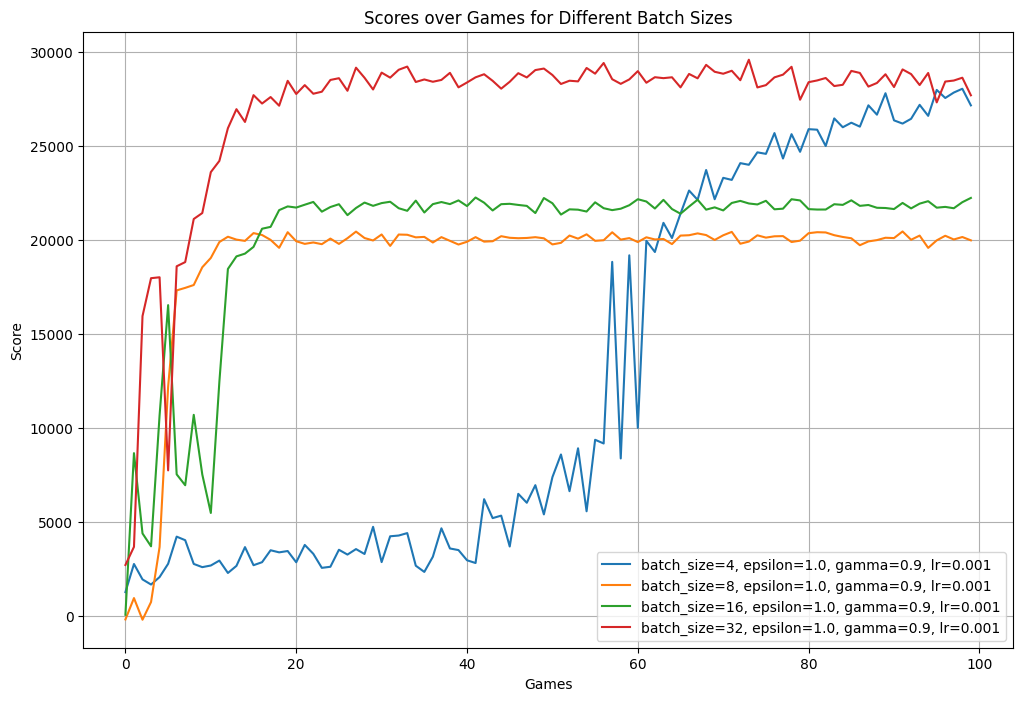

In [ ]:
# Plotting the scores
plt.figure(figsize=(12, 8))
for i, scores in enumerate(all_scores):
    plt.plot(scores, label=experiment_labels[i])
plt.xlabel('Games')
plt.ylabel('Score')
plt.title('Scores over Games for Different Batch Sizes')
plt.legend()
plt.grid(True)
plt.show()

the best result is for batch size = 32.

# **Effect of learning rate:**

In [ ]:
# Define lists of hyperparameters to explore
batch_sizes = [8]
epsilons = [1.0]
gammas = [0.9]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
n_games = 100

all_scores = []
experiment_labels = []
# Perform experiments for all combinations of hyperparameters
for batch_size in batch_sizes:
    for epsilon in epsilons:
        for gamma in gammas:
            for lr in learning_rates:
                experiment_label = f"batch_size={batch_size}, epsilon={epsilon}, gamma={gamma}, lr={lr}"
                print(f"Running experiment with {experiment_label}, n_games={n_games}")
                scores = doExp(batch_size=batch_size, epsilon=epsilon, gamma=gamma, lr=lr, n_games=n_games)
                all_scores.append(scores)
                experiment_labels.append(experiment_label)

Running experiment with batch_size=8, epsilon=1.0, gamma=0.9, lr=0.1, n_games=100
Episode 0: Reached max steps. Resetting environment.
episode 0, score 696.00, average score 696.00, epsilon 0.50
Episode 1: Reached max steps. Resetting environment.
episode 1, score 192.00, average score 444.00, epsilon 0.10
Episode 2: Reached max steps. Resetting environment.
episode 2, score 49.00, average score 312.33, epsilon 0.10
episode 3, score 406.00, average score 335.75, epsilon 0.10
episode 4, score 214.00, average score 311.40, epsilon 0.10
episode 5, score 194.00, average score 291.83, epsilon 0.10
episode 6, score 138.00, average score 269.86, epsilon 0.10
episode 7, score 241.00, average score 266.25, epsilon 0.10
episode 8, score 106.00, average score 248.44, epsilon 0.10
Episode 9: Reached max steps. Resetting environment.
episode 9, score 18.00, average score 225.40, epsilon 0.10
episode 10, score 579.00, average score 257.55, epsilon 0.10
Episode 11: Reached max steps. Resetting enviro

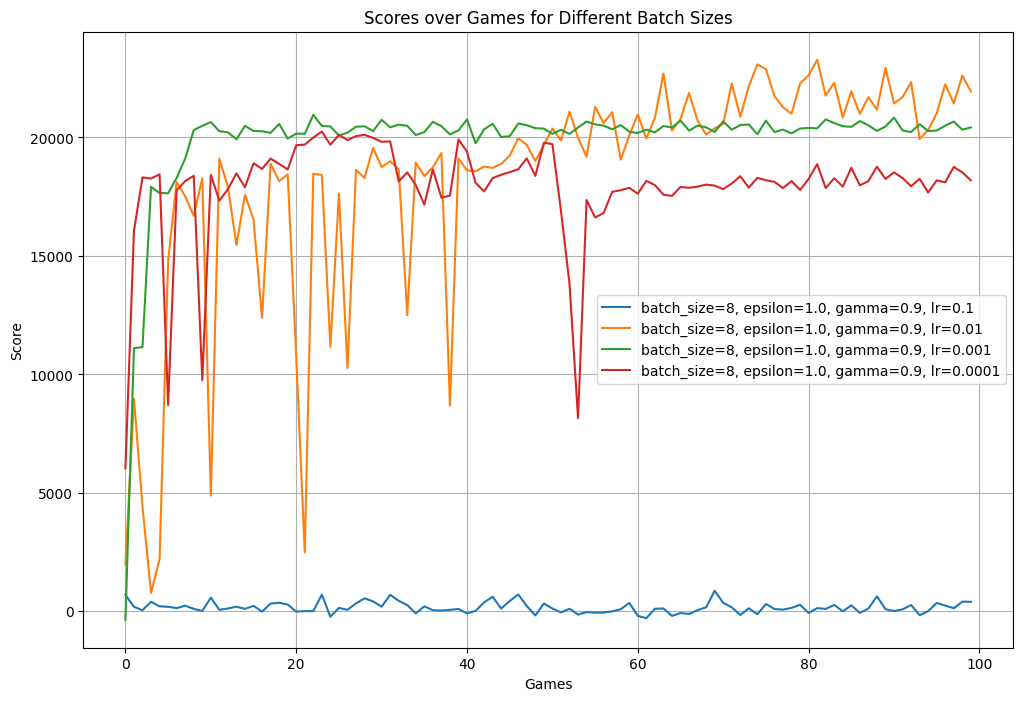

In [ ]:
# Plotting the scores
plt.figure(figsize=(12, 8))
for i, scores in enumerate(all_scores):
    plt.plot(scores, label=experiment_labels[i])
plt.xlabel('Games')
plt.ylabel('Score')
plt.title('Scores over Games for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

Best learning rate is 0.001. worst one is 0.1 which is not acceptable.

# **Effect of Epsilon:**

In [ ]:
# Define lists of hyperparameters to explore
batch_sizes = [8]
epsilons = [1.0, 0.8, 0.5, 0.1]
gammas = [0.9]
learning_rates = [0.001]
n_games = 100

all_scores = []
experiment_labels = []
# Perform experiments for all combinations of hyperparameters
for batch_size in batch_sizes:
    for epsilon in epsilons:
        for gamma in gammas:
            for lr in learning_rates:
                experiment_label = f"batch_size={batch_size}, epsilon={epsilon}, gamma={gamma}, lr={lr}"
                print(f"Running experiment with {experiment_label}, n_games={n_games}")
                scores = doExp(batch_size=batch_size, epsilon=epsilon, gamma=gamma, lr=lr, n_games=n_games)
                all_scores.append(scores)
                experiment_labels.append(experiment_label)

Running experiment with batch_size=8, epsilon=1.0, gamma=0.9, lr=0.001, n_games=100
Episode 0: Reached max steps. Resetting environment.
episode 0, score -93.00, average score -93.00, epsilon 0.50
Episode 1: Reached max steps. Resetting environment.
episode 1, score -279.00, average score -186.00, epsilon 0.10
Episode 2: Reached max steps. Resetting environment.
episode 2, score 5776.00, average score 1801.33, epsilon 0.10
episode 3, score 2294.00, average score 1924.50, epsilon 0.10
Episode 4: Reached max steps. Resetting environment.
episode 4, score 5048.00, average score 2549.20, epsilon 0.10
Episode 5: Reached max steps. Resetting environment.
episode 5, score 6310.00, average score 3176.00, epsilon 0.10
Episode 6: Reached max steps. Resetting environment.
episode 6, score 16678.00, average score 5104.86, epsilon 0.10
Episode 7: Reached max steps. Resetting environment.
episode 7, score 17974.00, average score 6713.50, epsilon 0.10
Episode 8: Reached max steps. Resetting environme

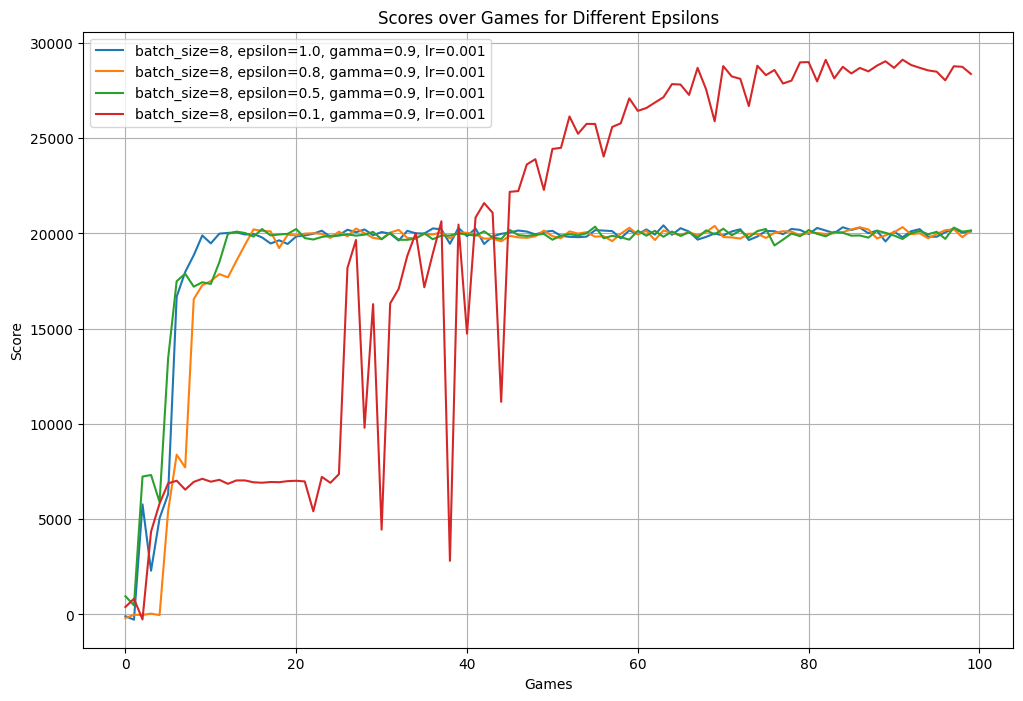

In [ ]:
# Plotting the scores
plt.figure(figsize=(12, 8))
for i, scores in enumerate(all_scores):
    plt.plot(scores, label=experiment_labels[i])
plt.xlabel('Games')
plt.ylabel('Score')
plt.title('Scores over Games for Different Epsilons')
plt.legend()
plt.grid(True)
plt.show()

Epsilon 0.1 is not acceptable because of its high noise. but values 1, 0.8 and 0.5 don't have so much difference.

# **Train final model:**

In [ ]:
batch_sizes = [32]
epsilons = [1.0]
gammas = [0.9]
learning_rates = [0.001]
n_games = 100

all_scores = []
experiment_labels = []
# Perform experiments for all combinations of hyperparameters
for batch_size in batch_sizes:
    for epsilon in epsilons:
        for gamma in gammas:
            for lr in learning_rates:
                experiment_label = f"batch_size={batch_size}, epsilon={epsilon}, gamma={gamma}, lr={lr}"
                print(f"Running experiment with {experiment_label}, n_games={n_games}")
                scores = doExp(batch_size=batch_size, epsilon=epsilon, gamma=gamma, lr=lr, n_games=n_games)
                all_scores.append(scores)
                experiment_labels.append(experiment_label)

Running experiment with batch_size=32, epsilon=1.0, gamma=0.9, lr=0.001, n_games=100
Episode 0: Reached max steps. Resetting environment.
episode 0, score 976.00, average score 976.00, epsilon 0.52
Episode 1: Reached max steps. Resetting environment.
episode 1, score 650.00, average score 813.00, epsilon 0.10
Episode 2: Reached max steps. Resetting environment.
episode 2, score 11390.00, average score 4338.67, epsilon 0.10
Episode 3: Reached max steps. Resetting environment.
episode 3, score 8863.00, average score 5469.75, epsilon 0.10
Episode 4: Reached max steps. Resetting environment.
episode 4, score 6530.00, average score 5681.80, epsilon 0.10
Episode 5: Reached max steps. Resetting environment.
episode 5, score 17734.00, average score 7690.50, epsilon 0.10
Episode 6: Reached max steps. Resetting environment.
episode 6, score 17500.00, average score 9091.86, epsilon 0.10
Episode 7: Reached max steps. Resetting environment.
episode 7, score 19986.00, average score 10453.62, epsilon

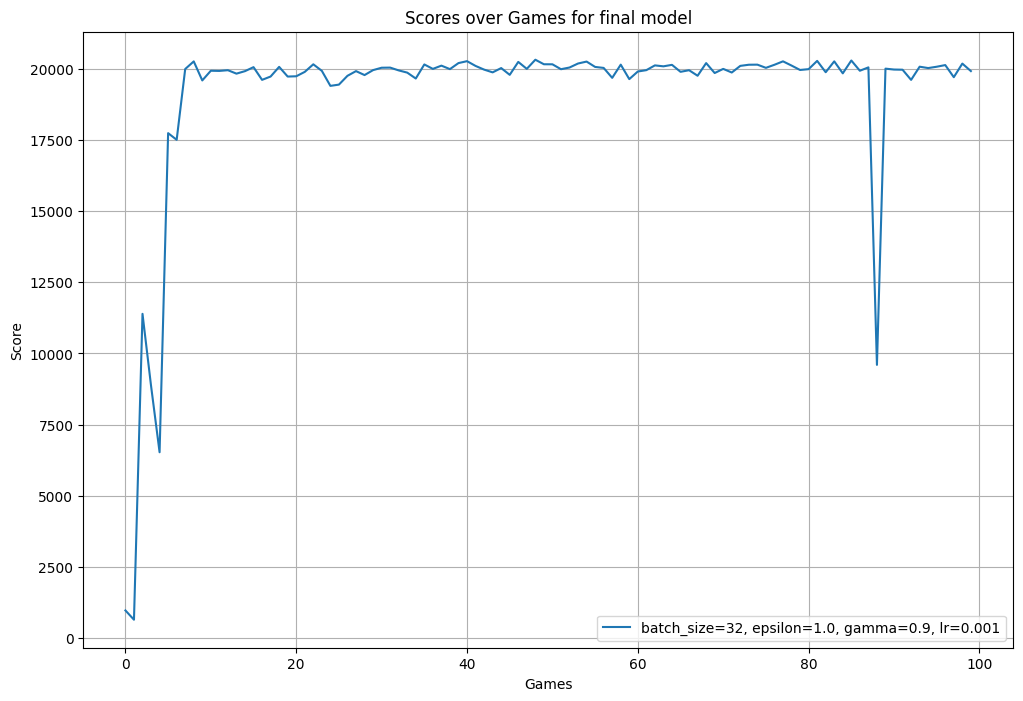

In [ ]:
# Plotting the scores
plt.figure(figsize=(12, 8))
for i, scores in enumerate(all_scores):
    plt.plot(scores, label=experiment_labels[i])
plt.xlabel('Games')
plt.ylabel('Score')
plt.title('Scores over Games for final model')
plt.legend()
plt.grid(True)
plt.show()

## (Bonus) Target Q Network

Instead of calculating the target q-value using the formula presented, you can use anonther Deep Neural Network to predict the target Q-values via regression!

Implementing the target Q network alonside the eval Q network can lead to more steady behavior of the final score.